<a href="https://colab.research.google.com/github/ItalianPepper/coronavirus_analysis/blob/master/coronavirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Siate responsabili per voi stessi e i vostri cari ed osservate le normative del Governo Italiano.

I grafici mostrano esclusivamente i dati della Protezione Civile.

Le previsioni considerano l'andamento del virus nel numero di giorni precedenti definiti dalla variabile 'look_back'.

Le previsioni sono soggette ad oscillazioni.

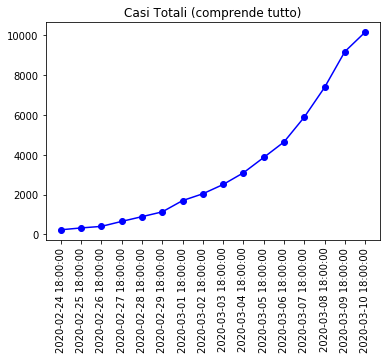

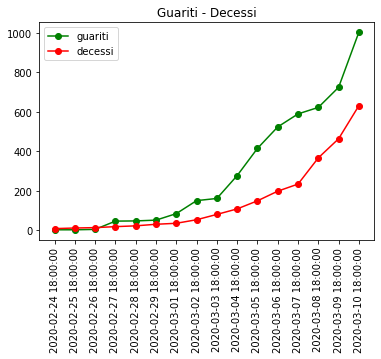

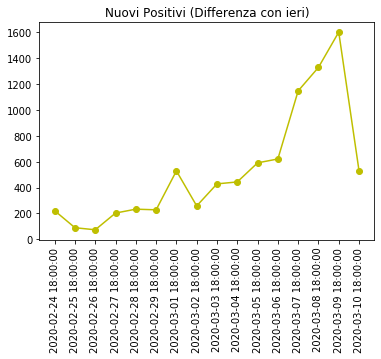

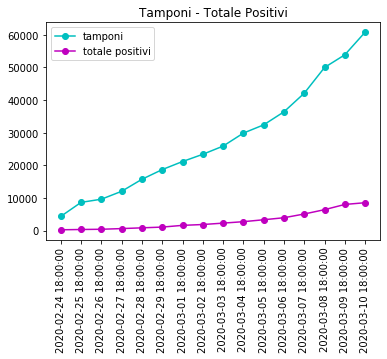

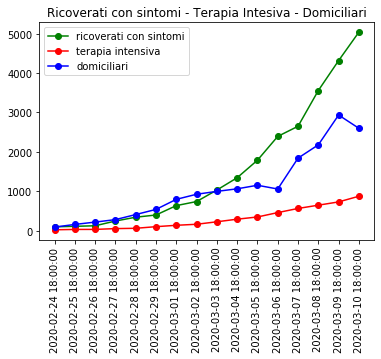

Linear SVR
---
LSVR-Previsioni Numero di Casi
Ultimo aggiornamento del  2020-03-10 18:00:00 :  10149
Previsione per domani: 12860
Previsione per dopodomani: 16137
Previsione fra 3 giorni: 20198
---
---
LSVR-Previsioni Guariti
Ultimo aggiornamento del  2020-03-10 18:00:00 :  1004
Previsione per domani: 1490
Previsione per dopodomani: 2087
Previsione fra 3 giorni: 2630
---
---
LSVR-Previsioni Decessi
Ultimo aggiornamento del  2020-03-10 18:00:00 :  631
Previsione per domani: 936
Previsione per dopodomani: 1123
Previsione fra 3 giorni: 1692
---
Linear Regression
---
LR-Previsioni Numero di Casi
Ultimo aggiornamento del  2020-03-10 18:00:00 :  10149
Previsione per domani: 12516
Previsione per dopodomani: 15505
Previsione fra 3 giorni: 18148
---
---
LR-Previsioni Guariti
Ultimo aggiornamento del  2020-03-10 18:00:00 :  1004
Previsione per domani: 1301
Previsione per dopodomani: 1514
Previsione fra 3 giorni: 1729
---
---
LR-Previsioni Decessi
Ultimo aggiornamento del  2020-03-10 18:00:00 :  

In [0]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
import numpy as np

# Download .csv file from official profile of Protezione Civile.
raw_git_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
csv_name = "dpc-covid19-ita-andamento-nazionale.csv"
urllib.request.urlretrieve(raw_git_url, csv_name)


df_ita_covid = pd.read_csv(csv_name, sep=",", header=0)
tot_casi_col = df_ita_covid["totale_casi"].tolist()
tot_healed_col = df_ita_covid["dimessi_guariti"].tolist()
tot_deaths_col = df_ita_covid["deceduti"].tolist()
dates_col = df_ita_covid["data"].tolist()
new_cases_col = df_ita_covid["nuovi_attualmente_positivi"].tolist()
tot_now_positive_col = df_ita_covid["totale_attualmente_positivi"].tolist()
tot_tamponi_col = df_ita_covid["tamponi"].tolist()

tot_recovery = df_ita_covid["ricoverati_con_sintomi"].tolist()
tot_dom = df_ita_covid["isolamento_domiciliare"].tolist()
intensitive_care = df_ita_covid["terapia_intensiva"].tolist()

last_date = dates_col[len(dates_col)-1]

# Total cases
plt.plot_date(dates_col, tot_casi_col, 'ob-', xdate=True, )
plt.title("Casi Totali (comprende tutto)")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Healed - Deaths
plt.plot_date(dates_col, tot_healed_col, 'og-', xdate=True)
plt.plot_date(dates_col, tot_deaths_col, 'or-', xdate=True)
plt.title("Guariti - Decessi")
plt.legend(["guariti", "decessi"])
plt.xticks(rotation=90)
plt.show()
plt.close()


# New Positives
plt.plot_date(dates_col, new_cases_col, 'oy-', xdate=True)
plt.title("Nuovi Positivi (Differenza con ieri)")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Swabs - Tot positives
plt.plot_date(dates_col, tot_tamponi_col, 'oc-', xdate=True)
plt.plot_date(dates_col, tot_now_positive_col, 'om-', xdate=True)
plt.title("Tamponi - Totale Positivi")
plt.legend(["tamponi", "totale positivi"])
plt.xticks(rotation=90)
plt.show()
plt.close()


# Tot Hospitalized - Intensitive Care - Home Isolation - Actual Positives
plt.plot_date(dates_col, tot_recovery, 'og-', xdate=True)
plt.plot_date(dates_col, intensitive_care, 'or-', xdate=True)
plt.plot_date(dates_col, tot_dom, 'ob-', xdate=True)
plt.title("Ricoverati con sintomi - Terapia Intesiva - Domiciliari")
plt.legend(["ricoverati con sintomi", "terapia intensiva", "domiciliari"])
plt.xticks(rotation=90)
plt.show()
plt.close()

def preprocessing(col_selected, look_back=1):
  
  x_mod = []
  y_mod = []

  for i in range(look_back, len(col_selected)):
    
    # Example look_back = 3:
    # -> i = 3:
    # x = {v[0], v[1], v[2]}
    # y = {v[3]}
    #
    # -> i = 4:
    # x = {v[1], v[2], v[3]}
    # y = {v[4]}
    # ecc...

    x_sample = col_selected[i-look_back:i]
    
    y_sample = col_selected[i]
    
    x_mod.append(x_sample)
    y_mod.append(y_sample)

  # That's the formula for the next day prediction:
  # X for next predictions is equal to last element of train set less the first
  # element of that vector. Then adding the last value of y.
  x_tmp = x_mod[len(x_mod)-1]
  y_tmp = y_mod[len(y_mod)-1]
  last_x = [x_tmp[i] for i in range(1, look_back)]
  last_x.append(y_tmp)


  # Transforming in np.array
  last_x_arr = np.array(last_x).reshape(1, look_back)
  x = np.array(x_mod).reshape(-1, look_back)
  y = np.array(y_mod)

  last_real_value = col_selected[len(col_selected)-1]
  
  return x, y, last_x_arr, last_x, last_real_value


def generate_prediction(model, last_x, last_x_arr, last_date,
                        last_real_value, title, look_back=1):
  
  print("---")
  print(title)
  
  #print("Ultimo aggiornamento del ", last_date, 
  #      ": ",col_selected[len(col_selected)-1])
  
  print("Ultimo aggiornamento del ", last_date, 
        ": ",last_real_value)

  prediction = model.predict(last_x_arr)
  round_prediction = int(prediction)

  print("Previsione per domani:", round_prediction)

  # Removing the first element from last_x and
  # adding at end the last prediction.
  # to create the next 2nd prediction (the day after tomorrow)

  sec_day_after = [last_x[i] for i in range(1, len(last_x))]
  sec_day_after.append(round_prediction)

  sec_day_after_arr = np.array(sec_day_after).reshape(1, look_back)
  prediction_sec = model.predict(sec_day_after_arr)
  round_prediction_sec = int(prediction_sec)

  print("Previsione per dopodomani:", round_prediction_sec)

  thr_day_after = [sec_day_after[i] for i in range(1, len(sec_day_after))]
  thr_day_after.append(round_prediction_sec)

  thr_day_after_arr = np.array(thr_day_after).reshape(1, look_back)
  prediction_thr = model.predict(thr_day_after_arr)
  round_prediction_thr = int(prediction_thr)

  print("Previsione fra 3 giorni:", round_prediction_thr)
  print("---")


def run_linear_svr(col_selected, last_date, title, look_back=1):
  
  x, y, last_x_arr, last_x, last_real_value = preprocessing(col_selected,
                                                            look_back)
  
  svr = LinearSVR(max_iter=1000000)
  #svr = SVR(kernel="poly", degree=2, C=100, epsilon=0.01)
  svr.fit(x, y)

  generate_prediction(svr, last_x, last_x_arr, last_date,
                      last_real_value, title, look_back)


def run_linear_regression(col_selected, last_date, title, look_back=1):
  x, y, last_x_arr, last_x, last_real_value = preprocessing(col_selected,
                                                            look_back)
  
  lin_reg = LinearRegression()
  lin_reg.fit(x, y)
  
  generate_prediction(lin_reg, last_x, last_x_arr, last_date,
                      last_real_value, title, look_back)


print("Linear SVR")

run_linear_svr(tot_casi_col, last_date, "LSVR-Previsioni Numero di Casi", look_back=5)
run_linear_svr(tot_healed_col, last_date, "LSVR-Previsioni Guariti", look_back=5)
run_linear_svr(tot_deaths_col, last_date, "LSVR-Previsioni Decessi", look_back=5)

print("Linear Regression")

run_linear_regression(tot_casi_col, last_date, "LR-Previsioni Numero di Casi", look_back=3)
run_linear_regression(tot_healed_col, last_date, "LR-Previsioni Guariti", look_back=3)
run_linear_regression(tot_deaths_col, last_date, "LR-Previsioni Decessi", look_back=3)